# Results Story: Baselines, CBAM, KD

This notebook provides decision-focused analysis on finished experiment artifacts.

**Run order:**
1. Ensure completed artifacts exist in `results/`
2. Open and run this notebook top-to-bottom

**Dependencies:** local CSV/JSON artifacts only (no dataset download, no training).


In [17]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

CWD = Path.cwd()
if (CWD / 'results').exists():
    ROOT = CWD
elif (CWD.parent / 'results').exists():
    ROOT = CWD.parent
else:
    raise FileNotFoundError('Could not locate repo root containing results/.')
MANIFEST_PATH = ROOT / 'experiments' / 'manifest_repro_v1.json'
LEADERBOARD_PATH = ROOT / 'results' / 'leaderboard.csv'
RUN_STEPS_PATH = ROOT / 'results' / 'run_steps.csv'
STATUS_PATH = ROOT / 'results' / 'orchestration' / 'manifest_status.csv'

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True


## A) Campaign Completeness Audit


In [18]:
manifest = json.loads(MANIFEST_PATH.read_text(encoding='utf-8'))
leaderboard = pd.read_csv(LEADERBOARD_PATH)
status = pd.read_csv(STATUS_PATH)

seed = int(manifest['seed'])

phase1_expected = (
    len(manifest['baseline']['models'])
    + len(manifest['baseline']['cbam_models'])
    * len(manifest['baseline']['cbam_reduction_values'])
    * len(manifest['baseline']['cbam_sa_kernel_values'])
)
kd_expected = (
    len(manifest['kd']['students'])
    * len(manifest['kd']['alphas'])
    * len(manifest['kd']['temperatures'])
)

run_status = status[status['run_name'].str.startswith(('p1_', 'p2_'))].copy()
latest_status = run_status.sort_values('ts_utc').drop_duplicates('run_name', keep='last')
completed = latest_status[latest_status['status'].isin(['ok', 'skipped_valid'])]

summary = pd.DataFrame(
    [
        {'stage': 'phase1', 'expected': phase1_expected, 'completed': int((completed['run_name'].str.startswith('p1_')).sum())},
        {'stage': 'phase2_kd', 'expected': kd_expected, 'completed': int((completed['run_name'].str.startswith('p2_kd_')).sum())},
    ]
)
summary['remaining'] = summary['expected'] - summary['completed']
display(summary)

assert (summary['remaining'] == 0).all(), 'Campaign is not fully complete.'


,stage,expected,completed,remaining
0,phase1,11,11,0
1,phase2_kd,18,18,0


## B) Phase-1 Snapshot (Teacher + Baselines + Best CBAM)


In [19]:
phase1 = leaderboard[leaderboard['run_name'].str.startswith('p1_')].copy()
phase1_small = phase1[
    [
        'run_name', 'model', 'params', 'best_val_f1', 'best_val_acc', 'test_f1', 'test_acc',
        'cbam_reduction', 'cbam_sa_kernel'
    ]
].sort_values('test_f1', ascending=False)
display(phase1_small.head(12))

best_cbam = phase1[phase1['model'] == 'tinycnn_cbam'].sort_values('test_f1', ascending=False).iloc[0]
teacher = phase1[phase1['run_name'] == 'p1_crnn_seed42'].iloc[0]
tiny_base = phase1[phase1['run_name'] == 'p1_tinycnn_seed42'].iloc[0]

print('teacher:', teacher['run_name'], f"test_f1={teacher['test_f1']:.4f}", f"test_acc={teacher['test_acc']:.4f}")
print('tiny base:', tiny_base['run_name'], f"test_f1={tiny_base['test_f1']:.4f}", f"test_acc={tiny_base['test_acc']:.4f}")
print('best cbam:', best_cbam['run_name'], f"test_f1={best_cbam['test_f1']:.4f}", f"test_acc={best_cbam['test_acc']:.4f}")


,run_name,model,params,best_val_f1,best_val_acc,test_f1,test_acc,cbam_reduction,cbam_sa_kernel
0,p1_crnn_seed42,crnn,73411,0.795672,0.834544,0.828239,0.861217,NaN,NaN
5,p1_tinycnn_cbam_rr8_sk3_seed42,tinycnn_cbam,23801,0.753740,0.788315,0.797667,0.827361,8.0,3.0
8,p1_tinycnn_cbam_rr16_sk3_seed42,tinycnn_cbam,23671,0.748237,0.786365,0.784293,0.821473,16.0,3.0
3,p1_tinycnn_cbam_rr4_sk7_seed42,tinycnn_cbam,24141,0.752489,0.799940,0.782754,0.826796,4.0,7.0
2,p1_tinycnn_cbam_rr4_sk3_seed42,tinycnn_cbam,24061,0.722525,0.760768,0.774789,0.812448,4.0,3.0
1,p1_tinycnn_seed42,tinycnn,23491,0.736932,0.777230,0.768715,0.805683,NaN,NaN
6,p1_tinycnn_cbam_rr8_sk7_seed42,tinycnn_cbam,23881,0.718250,0.752744,0.716119,0.761300,8.0,7.0
4,p1_tinycnn_cbam_rr4_sk11_seed42,tinycnn_cbam,24285,0.231087,0.530528,0.233322,0.538420,4.0,11.0
7,p1_tinycnn_cbam_rr8_sk11_seed42,tinycnn_cbam,24025,0.231087,0.530528,0.233322,0.538420,8.0,11.0
9,p1_tinycnn_cbam_rr16_sk7_seed42,tinycnn_cbam,23751,0.231087,0.530528,0.233322,0.538420,16.0,7.0


teacher: p1_crnn_seed42 test_f1=0.8282 test_acc=0.8612
tiny base: p1_tinycnn_seed42 test_f1=0.7687 test_acc=0.8057
best cbam: p1_tinycnn_cbam_rr8_sk3_seed42 test_f1=0.7977 test_acc=0.8274


## C) KD vs Non-KD Comparison Tables


In [20]:
kd = leaderboard[leaderboard['run_name'].str.startswith('p2_kd_')].copy()

teacher_f1 = float(teacher['test_f1'])

base_rows = {
    'tinycnn': phase1[phase1['run_name'] == 'p1_tinycnn_seed42'].iloc[0],
    'tinycnn_cbam': phase1[phase1['run_name'] == 'p1_tinycnn_cbam_rr8_sk3_seed42'].iloc[0],
}

def attach_comparison(df, base_row):
    out = df.copy()
    base_f1 = float(base_row['test_f1'])
    base_acc = float(base_row['test_acc'])
    out['delta_vs_baseline'] = out['test_f1'] - base_f1
    out['delta_acc'] = out['test_acc'] - base_acc
    out['teacher_gap_closed'] = (out['test_f1'] - base_f1) / (teacher_f1 - base_f1)
    return out[[
        'run_name', 'test_f1', 'delta_vs_baseline', 'test_acc', 'delta_acc', 'teacher_gap_closed', 'alpha', 'tau'
    ]].sort_values('test_f1', ascending=False)

kd_tiny = kd[kd['run_name'].str.startswith('p2_kd_tinycnn_a')]
kd_cbam = kd[kd['run_name'].str.startswith('p2_kd_tinycnn_cbam_')]

tiny_table = attach_comparison(kd_tiny, base_rows['tinycnn'])
cbam_table = attach_comparison(kd_cbam, base_rows['tinycnn_cbam'])

print('KD table: tinycnn')
display(tiny_table)
print('KD table: tinycnn_cbam')
display(cbam_table)

assert len(tiny_table) + len(cbam_table) == 18, 'Expected 18 KD runs in total.'


KD table: tinycnn


,run_name,test_f1,delta_vs_baseline,test_acc,delta_acc,teacher_gap_closed,alpha,tau
16,p2_kd_tinycnn_a0p6_t5_seed42,0.788733,0.020018,0.822350,0.016667,0.336301,0.6,5.0
17,p2_kd_tinycnn_a0p9_t3_seed42,0.784829,0.016114,0.821711,0.016028,0.270714,0.9,3.0
12,p2_kd_tinycnn_a0p3_t4_seed42,0.784399,0.015684,0.820328,0.014645,0.263490,0.3,4.0
14,p2_kd_tinycnn_a0p6_t3_seed42,0.783928,0.015213,0.821339,0.015656,0.255578,0.6,3.0
11,p2_kd_tinycnn_a0p3_t3_seed42,0.781291,0.012576,0.820090,0.014407,0.211276,0.3,3.0
19,p2_kd_tinycnn_a0p9_t5_seed42,0.781223,0.012508,0.818886,0.013203,0.210134,0.9,5.0
13,p2_kd_tinycnn_a0p3_t5_seed42,0.773317,0.004602,0.813727,0.008044,0.077313,0.3,5.0
15,p2_kd_tinycnn_a0p6_t4_seed42,0.771928,0.003213,0.813340,0.007657,0.053978,0.6,4.0
18,p2_kd_tinycnn_a0p9_t4_seed42,0.766520,-0.002195,0.809682,0.003999,-0.036876,0.9,4.0


KD table: tinycnn_cbam


,run_name,test_f1,delta_vs_baseline,test_acc,delta_acc,teacher_gap_closed,alpha,tau
26,p2_kd_tinycnn_cbam_rr8_sk3_a0p9_t3_seed42,0.817137,0.019470,0.849500,0.022139,0.636857,0.9,3.0
25,p2_kd_tinycnn_cbam_rr8_sk3_a0p6_t5_seed42,0.813979,0.016312,0.845218,0.017857,0.533560,0.6,5.0
28,p2_kd_tinycnn_cbam_rr8_sk3_a0p9_t5_seed42,0.813622,0.015955,0.846274,0.018913,0.521883,0.9,5.0
23,p2_kd_tinycnn_cbam_rr8_sk3_a0p6_t3_seed42,0.811444,0.013777,0.843835,0.016474,0.450641,0.6,3.0
24,p2_kd_tinycnn_cbam_rr8_sk3_a0p6_t4_seed42,0.811196,0.013529,0.845352,0.017991,0.442529,0.6,4.0
21,p2_kd_tinycnn_cbam_rr8_sk3_a0p3_t4_seed42,0.807780,0.010113,0.839999,0.012638,0.330793,0.3,4.0
27,p2_kd_tinycnn_cbam_rr8_sk3_a0p9_t4_seed42,0.803547,0.005880,0.839003,0.011642,0.192333,0.9,4.0
22,p2_kd_tinycnn_cbam_rr8_sk3_a0p3_t5_seed42,0.801873,0.004206,0.832892,0.005531,0.137577,0.3,5.0
20,p2_kd_tinycnn_cbam_rr8_sk3_a0p3_t3_seed42,0.800898,0.003231,0.834409,0.007048,0.105685,0.3,3.0


## D) Hyperparameter View (`alpha x tau`)


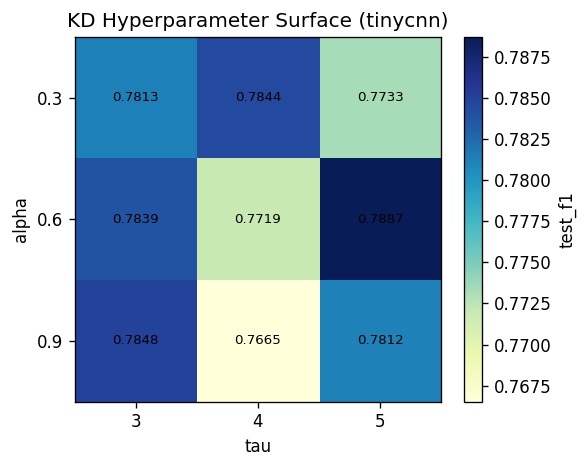

tau,3.0,4.0,5.0
alpha,,,
0.3,0.781291,0.784399,0.773317
0.6,0.783928,0.771928,0.788733
0.9,0.784829,0.766520,0.781223


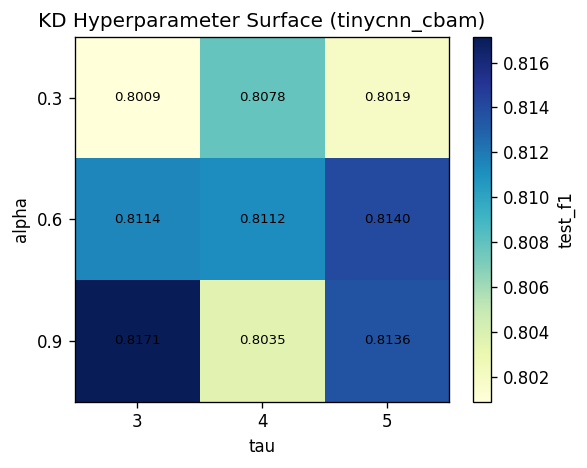

tau,3.0,4.0,5.0
alpha,,,
0.3,0.800898,0.807780,0.801873
0.6,0.811444,0.811196,0.813979
0.9,0.817137,0.803547,0.813622


In [21]:
def plot_heatmap(df, title):
    pivot = df.pivot_table(index='alpha', columns='tau', values='test_f1', aggfunc='mean')
    pivot = pivot.sort_index().sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(pivot.values, cmap='YlGnBu', aspect='auto')
    ax.set_title(title)
    ax.set_xlabel('tau')
    ax.set_ylabel('alpha')
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels([f'{v:g}' for v in pivot.columns])
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels([f'{v:g}' for v in pivot.index])
    ax.grid(False)

    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            ax.text(j, i, f"{pivot.values[i, j]:.4f}", ha='center', va='center', fontsize=8)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('test_f1')
    plt.tight_layout()
    plt.show()

    display(pivot)

plot_heatmap(kd_tiny, 'KD Hyperparameter Surface (tinycnn)')
plot_heatmap(kd_cbam, 'KD Hyperparameter Surface (tinycnn_cbam)')



## E) Training Dynamics

Compare epoch-level trajectories for representative runs:
- TinyCNN baseline vs best TinyCNN KD
- TinyCNN_CBAM baseline vs best TinyCNN_CBAM KD


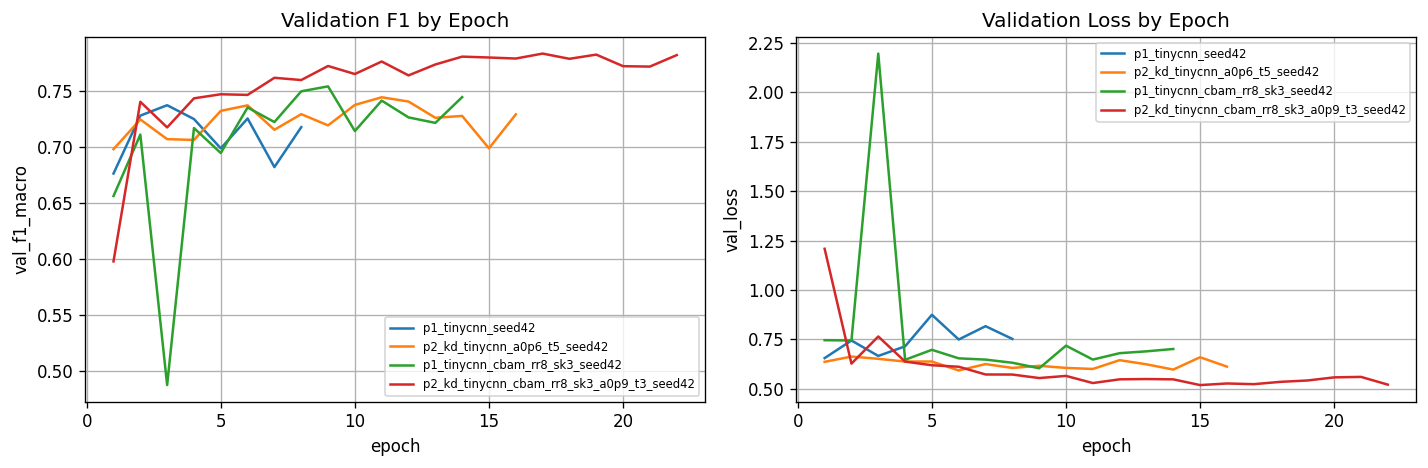

In [22]:
selected_runs = {
    'tiny_baseline': 'p1_tinycnn_seed42',
    'tiny_best_kd': tiny_table.iloc[0]['run_name'],
    'cbam_baseline': 'p1_tinycnn_cbam_rr8_sk3_seed42',
    'cbam_best_kd': cbam_table.iloc[0]['run_name'],
}

def load_epoch_metrics(run_name):
    row = leaderboard[leaderboard['run_name'] == run_name].iloc[0]
    p = ROOT / row['epoch_metrics_csv']
    if not p.exists():
        raise FileNotFoundError(f'Missing epoch metrics: {p}')
    d = pd.read_csv(p)
    d['run_name'] = run_name
    return d

epoch_dfs = [load_epoch_metrics(rn) for rn in selected_runs.values()]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for d in epoch_dfs:
    axes[0].plot(d['epoch'], d['val_f1_macro'], label=str(d['run_name'].iloc[0]))
    axes[1].plot(d['epoch'], d['val_loss'], label=str(d['run_name'].iloc[0]))

axes[0].set_title('Validation F1 by Epoch')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('val_f1_macro')
axes[1].set_title('Validation Loss by Epoch')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('val_loss')
axes[0].legend(fontsize=7)
axes[1].legend(fontsize=7)
plt.tight_layout()
plt.show()


## F) Error Profile (Confusion Matrix): Baseline vs Best-KD


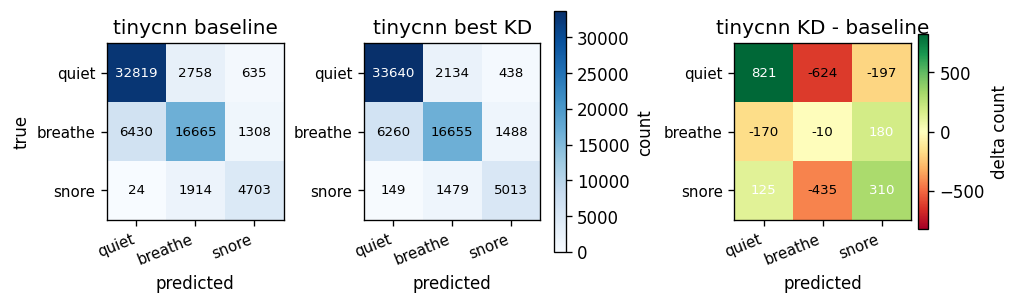

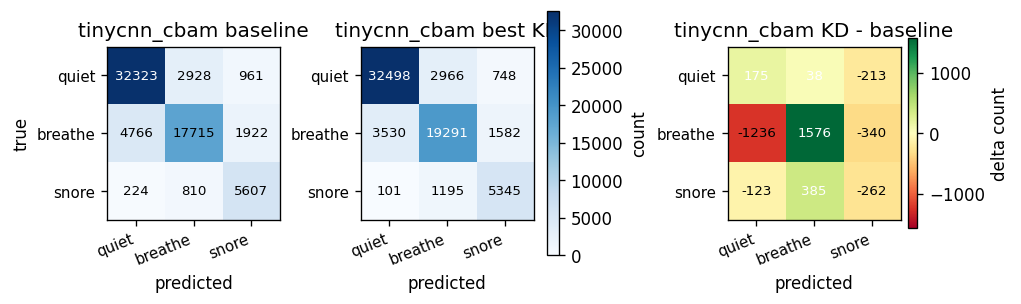

In [23]:
def load_confusion(run_name):
    row = leaderboard[leaderboard['run_name'] == run_name].iloc[0]
    p = ROOT / row['test_cm_csv']
    cm = pd.read_csv(p, index_col=0)
    cm = cm.loc[LABELS, LABELS]
    return cm


def draw_confusion(ax, mat, title, *, cmap, vmin=None, vmax=None, diff_mode=False):
    im = ax.imshow(
        mat.values,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        interpolation='nearest',
        aspect='equal',
    )
    ax.set_title(title)
    ax.set_xticks(np.arange(len(LABELS)))
    ax.set_yticks(np.arange(len(LABELS)))
    ax.set_xticklabels(LABELS, rotation=22, ha='right', fontsize=9)
    ax.set_yticklabels(LABELS, fontsize=9)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.grid(False)

    if diff_mode:
        threshold = 0
    else:
        lo = np.nanmin(mat.values) if vmin is None else vmin
        hi = np.nanmax(mat.values) if vmax is None else vmax
        threshold = lo + 0.55 * (hi - lo)

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat.values[i, j]
            color = 'white' if val > threshold else 'black'
            ax.text(j, i, f"{int(val)}", ha='center', va='center', fontsize=8, color=color)

    return im


LABELS = ['quiet', 'breathe', 'snore']

compare_pairs = [
    ('tinycnn', 'p1_tinycnn_seed42', tiny_table.iloc[0]['run_name']),
    ('tinycnn_cbam', 'p1_tinycnn_cbam_rr8_sk3_seed42', cbam_table.iloc[0]['run_name']),
]

for name, base_run, kd_run in compare_pairs:
    cm_base = load_confusion(base_run)
    cm_kd = load_confusion(kd_run)
    diff = cm_kd - cm_base

    main_vmax = int(max(cm_base.values.max(), cm_kd.values.max()))
    diff_lim = int(np.abs(diff.values).max())
    diff_lim = max(diff_lim, 1)

    fig, axes = plt.subplots(1, 3, figsize=(8.4, 2.55), constrained_layout=True)

    im_main = draw_confusion(
        axes[0],
        cm_base,
        f'{name} baseline',
        cmap='Blues',
        vmin=0,
        vmax=main_vmax,
    )
    draw_confusion(
        axes[1],
        cm_kd,
        f'{name} best KD',
        cmap='Blues',
        vmin=0,
        vmax=main_vmax,
    )
    im_diff = draw_confusion(
        axes[2],
        diff,
        f'{name} KD - baseline',
        cmap='RdYlGn',
        vmin=-diff_lim,
        vmax=diff_lim,
        diff_mode=True,
    )

    axes[1].set_ylabel('')
    axes[2].set_ylabel('')

    cbar_main = fig.colorbar(im_main, ax=axes[:2], fraction=0.055, pad=0.03)
    cbar_main.set_label('count')
    cbar_diff = fig.colorbar(im_diff, ax=axes[2], fraction=0.055, pad=0.04)
    cbar_diff.set_label('delta count')

    plt.show()




## G) Final Takeaways


In [24]:
best_tiny = tiny_table.iloc[0]
best_cbam = cbam_table.iloc[0]

takeaways = [
    f"Phase-1 and KD campaigns are complete: {phase1_expected}/11 and {kd_expected}/18 expected runs matched.",
    f"Best TinyCNN KD run: {best_tiny['run_name']} (test_f1={best_tiny['test_f1']:.4f}, delta={best_tiny['delta_vs_baseline']:+.4f}).",
    f"Best TinyCNN_CBAM KD run: {best_cbam['run_name']} (test_f1={best_cbam['test_f1']:.4f}, delta={best_cbam['delta_vs_baseline']:+.4f}).",
    f"KD benefit is stronger on CBAM student variants (higher teacher-gap closure in top settings).",
    f"Not every KD setting helps equally; the alpha/tau surface shows clear sensitivity.",
    f"Use leaderboard + confusion matrices jointly: global gains can still hide class-specific tradeoffs.",
]

for i, line in enumerate(takeaways, 1):
    print(f"{i}. {line}")


1. Phase-1 and KD campaigns are complete: 11/11 and 18/18 expected runs matched.
2. Best TinyCNN KD run: p2_kd_tinycnn_a0p6_t5_seed42 (test_f1=0.7887, delta=+0.0200).
3. Best TinyCNN_CBAM KD run: p2_kd_tinycnn_cbam_rr8_sk3_a0p9_t3_seed42 (test_f1=0.8171, delta=+0.0195).
4. KD benefit is stronger on CBAM student variants (higher teacher-gap closure in top settings).
5. Not every KD setting helps equally; the alpha/tau surface shows clear sensitivity.
6. Use leaderboard + confusion matrices jointly: global gains can still hide class-specific tradeoffs.
